<a href="https://colab.research.google.com/github/Liub-ov/data_analysis_2023/blob/main/Lab4_Peleshenko_FI32mn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers
import numpy as np
import random
import io
from transformers import pipeline, RobertaForMaskedLM, RobertaTokenizer
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
from keras.applications import vgg19
from IPython.display import Image, display

In [ ]:
#завдання 1

path = "/content/sample_data/Lisova_pisnya.txt"

In [ ]:
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 92883
Total chars: 60
Number of sequences: 30948


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
epochs = 40
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

242/242 [==============================] - 33s 126ms/step - loss: 2.7205

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "й лиш побратаємось. м а в к а           "
...Generated:                                                                                                                                                                                                                                                                                                                                                                                                                  
-
...Diversity: 0.5
...Generating with seed: "й лиш побратаємось. м а в к а           "
...Generated:               в а ко на я зне воланя) я               вась! т у в а с ка за вося ну купони   ка ке те вівить яй віли, явіти  о віко, я зіроли, в о берні зо вокий ни вони ну віть вора вона ся пося воне воневом я не ко же не,  та та та ла врина  в к а к ста побо на наме вилу, не на вовася не 

In [ ]:
#model = RobertaForMaskedLM.from_pretrained("ukr-roberta-base")
#tokenizer = RobertaTokenizer.from_pretrained("ukr-roberta-base")

#завдання 2
classifier = pipeline("sentiment-analysis")
classifier("Сьогодні неймовірно гарний сонячний день.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.6169228553771973}]

In [ ]:
classifier(
    ["Сьогодні неймовірно гарний сонячний день", "Ненавиджу такі дні"]
)

[{'label': 'POSITIVE', 'score': 0.6526039838790894},
 {'label': 'NEGATIVE', 'score': 0.7566262483596802}]

In [ ]:
classifier = pipeline("zero-shot-classification")
classifier(
    "Людина, яка вміє керувати минулим, керує і майбутнім",
    candidate_labels=["поезія", "цитати", "життя"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'Людина, яка вміє керувати минулим, керує і майбутнім',
 'labels': ['життя', 'поезія', 'цитати'],
 'scores': [0.40398502349853516, 0.40286263823509216, 0.19315238296985626]}

In [ ]:
generator = pipeline("text-generation")
generator("У цьому курсі ми навчимось ")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'У цьому курсі ми навчимось федно скезридей,'}]

In [ ]:
generator = pipeline("text-generation", model="distilgpt2")
generator(
    "У цьому курсі ми навчимось як робити",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'У цьому курсі ми навчимось як робити �'},
 {'generated_text': 'У цьому курсі ми навчимось як робитиа'}]

In [ ]:
unmasker = pipeline("fill-mask")
unmasker("Тарас Шевченко – великий український <mask>.", top_k=2)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.6357361674308777,
  'token': 12686,
  'token_str': '»',
  'sequence': 'Тарас Шевченко – великий український».'},
 {'score': 0.03432747721672058,
  'token': 36709,
  'token_str': 'с',
  'sequence': 'Тарас Шевченко – великий українськийс.'}]

In [ ]:
unmasker("Taras Shevchenko is a great Ukrainian <mask>.", top_k=2)

[{'score': 0.2646377384662628,
  'token': 5226,
  'token_str': ' journalist',
  'sequence': 'Taras Shevchenko is a great Ukrainian journalist.'},
 {'score': 0.17095081508159637,
  'token': 3331,
  'token_str': ' writer',
  'sequence': 'Taras Shevchenko is a great Ukrainian writer.'}]

In [ ]:
ner = pipeline("ner", grouped_entities=True)
ner("Мене звати Люба і я навчаюсь у КПІ.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity_group': 'LOC',
  'score': 0.5107358,
  'word': 'Л',
  'start': 11,
  'end': 12},
 {'entity_group': 'ORG',
  'score': 0.40772122,
  'word': '##юб',
  'start': 12,
  'end': 14},
 {'entity_group': 'LOC',
  'score': 0.31541803,
  'word': '##а',
  'start': 14,
  'end': 15},
 {'entity_group': 'LOC',
  'score': 0.35556018,
  'word': '##ч',
  'start': 23,
  'end': 24},
 {'entity_group': 'LOC',
  'score': 0.64996845,
  'word': 'К',
  'start': 31,
  'end': 32}]

In [ ]:
ner("My name is Liuba and I study at KPI.")

[{'entity_group': 'PER',
  'score': 0.99631417,
  'word': 'Liuba',
  'start': 11,
  'end': 16},
 {'entity_group': 'ORG',
  'score': 0.9966562,
  'word': 'KPI',
  'start': 32,
  'end': 35}]

In [ ]:
question_answerer = pipeline("question-answering")
question_answerer(
    question="Де я навчаюсь?",
    context="Мене звати Люба і я навчаюсь у КПІ.",
)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.13014808297157288,
 'start': 0,
 'end': 15,
 'answer': 'Мене звати Люба'}

In [86]:
#завдання 3

base_image_path = "/content/sample_data/base-photo.jpg"
style_reference_image_path = "/content/sample_data/pes2.jpg"

result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

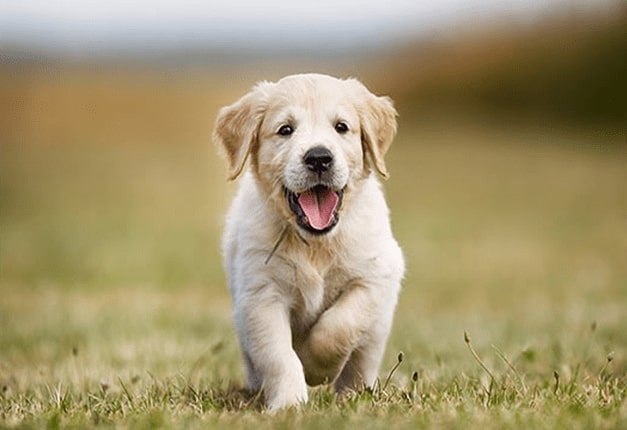

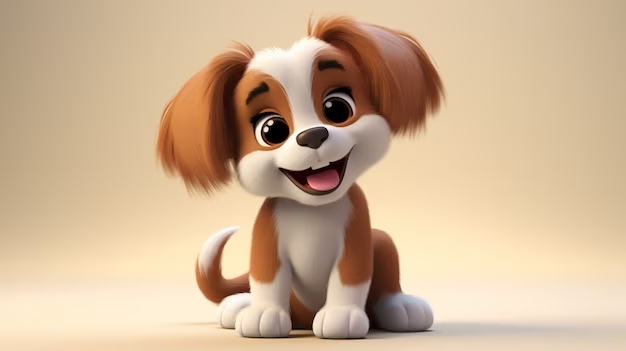

In [87]:
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [88]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [89]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [90]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [91]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [92]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [93]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 100
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 5 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 5: loss=3052.24
Iteration 10: loss=2309.57
Iteration 15: loss=1955.08
Iteration 20: loss=1754.76
Iteration 25: loss=1617.41
Iteration 30: loss=1514.51
Iteration 35: loss=1432.43
Iteration 40: loss=1365.17
Iteration 45: loss=1308.57
Iteration 50: loss=1260.19
Iteration 55: loss=1217.99
Iteration 60: loss=1180.78
Iteration 65: loss=1147.57
Iteration 70: loss=1117.80
Iteration 75: loss=1090.78
Iteration 80: loss=1066.12
Iteration 85: loss=1043.51
Iteration 90: loss=1022.78
Iteration 95: loss=1003.63
Iteration 100: loss=985.84


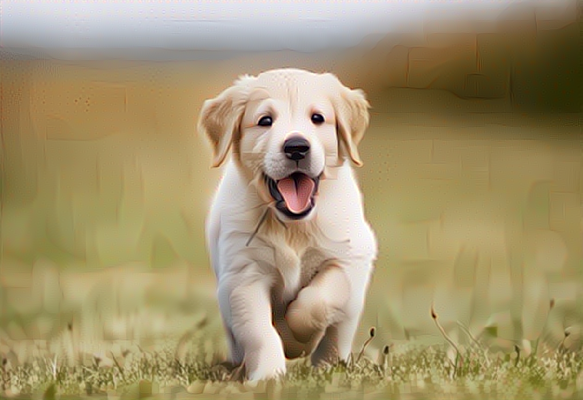

In [94]:
display(Image(result_prefix + "_at_iteration_100.png"))